In [1]:
# coding: utf-8
import sys
import os
import numpy as np
from numpy import tile
from sklearn.preprocessing import normalize
import torch.nn.functional as F
import scipy
import matplotlib.pyplot as plt
import math
from scipy import ndimage, misc
from PIL import Image
from collections import Counter
from sklearn.utils import shuffle
from numba import jit, njit, vectorize, cuda
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.autograd as autograd
from torch.autograd import Variable
from torch import optim, nn
from torchattacks.attack import Attack
import gc
torch.set_default_dtype(torch.float64)

In [2]:
class BAM5Layer(nn.Module):
    def __init__(self, a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes, mode='orth'):
        super().__init__()
        self.W1 = nn.Parameter(0.1 * torch.randn(a_vnodes, h1_nodes))
        self.W2 = nn.Parameter(0.1 * torch.randn(h1_nodes, h2_nodes))
        self.W3 = nn.Parameter(0.1 * torch.randn(h2_nodes, h3_nodes))
        self.W4 = nn.Parameter(0.1 * torch.randn(h3_nodes, b_vnodes))

        nn.init.orthogonal_(self.W1)
        nn.init.orthogonal_(self.W2)
        nn.init.orthogonal_(self.W3)
        nn.init.orthogonal_(self.W4)

        self.loss_a = []
        self.loss_b = []
        
        self.mode = mode

    def a_forward_b(self, a):
        h1 = torch.tanh(a @ self.W1)
        h2 = torch.tanh(h1 @ self.W2)
        h3 = torch.tanh(h2 @ self.W3)
        b_out = h3 @ self.W4
        return b_out, h1, h2, h3

    def b_forward_a(self, b):
        h3 = torch.tanh(b @ self.W4.T)
        h2 = torch.tanh(h3 @ self.W3.T)
        h1 = torch.tanh(h2 @ self.W2.T)
        a_out = h1 @ self.W1.T
        return a_out, h1, h2, h3
    
    def forward(self, sample_input, direction='a2b'):
        if direction  == 'a2b':
            visible_b, _, _, _ = self.a_forward_b(sample_input)
            return visible_b
        elif direction == 'b2a':
            visible_a, _, _, _ = self.b_forward_a(sample_input)
            return visible_a
        
    def orth_metric(self, W):
        W = W.detach()
        row, column = W.shape
        if row > column:
            WtW = W.T @ W
        else:
            WtW = W @ W.T
        mask = 1 - torch.eye(WtW.size(0), device=W.device)
        metric = torch.norm(WtW * mask, p='fro')  # Frobenius norm
        return metric
    
    def criterion(self, y_true, y_pred):
        return torch.nn.functional.mse_loss(y_true, y_pred)
    
    def sat(self, x):
        x[x > 2] = 2
        x[x < -2] = -2
        return x

    def bsra(self, pat_a, pat_b, epoches):
        pat_a.requires_grad = True
        pat_b.requires_grad = True
        for ix in range(epoches):

            # Forward pass A -> B
            # Apply subspace rotation to W3 only
            b_out, h1_a, h2_a, h3_a = self.a_forward_b(pat_a)
            
            h3_target = pat_b @ self.W4.T
            u, _, v = torch.linalg.svd(h3_target.T @ h3_a)
            self.W3.data = self.W3.data @ v.T @ u.T

            # Forward pass B -> A
            # Apply subspace rotation to W2 only
            a_out, h1_b, h2_b, h3_b = self.b_forward_a(pat_b)

            h1_target = pat_a @ self.W1
            u, _, v = torch.linalg.svd(h1_target.T @ h1_b)
            self.W2.data = u @ v @ self.W2.data

            # now update the outer circle
            # Forward pass A -> B
            b_out, h1_a, h2_a, h3_a = self.a_forward_b(pat_a)
            b_out = self.sat(b_out)
            u, _, v = torch.linalg.svd(pat_b.T @ b_out)
            self.W4.data = self.W4.data @ v.T @ u.T

            # Forward pass B -> A
            a_out, h1_b, h2_b, h3_b = self.b_forward_a(pat_b)
            a_out = self.sat(a_out)
            u, _, v = torch.linalg.svd(pat_a.T @ a_out)
            self.W1.data = u @ v @ self.W1.data

            loss_b = self.criterion(pat_b, b_out)
            self.loss_b.append(loss_b.item())
            grad_b = torch.autograd.grad(loss_b, pat_b, retain_graph=True, create_graph=True)[0]
            loss_gb = F.cosine_similarity(grad_b, b_out, dim=-1).mean()

            loss_a = self.criterion(pat_a, a_out)
            self.loss_a.append(loss_a.item())
            grad_a = torch.autograd.grad(loss_a, pat_a, retain_graph=True, create_graph=True)[0]
            loss_ga = F.cosine_similarity(grad_a, a_out, dim=-1).mean()

            loss_pred = self.criterion(pat_a, torch.sign(a_out)) \
            + self.criterion(pat_b, torch.sign(b_out))


            del u, v
            gc.collect()
            
            if loss_pred == 0:
                break

            print("Epoch:", ix + 1, "Loss A:", loss_a.item(), "Loss B:", loss_b.item())
            print("Grad Loss A: ", loss_ga.item(), 'Grad Loss B: ', loss_gb.item())
            print("Pred Loss:", loss_pred.item())

        return self.W1, self.W2, self.W3, self.W4
    
    def bbp(self, pat_a, pat_b, epoches=100, lr=1e-4):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        pat_a.requires_grad = True
        pat_b.requires_grad = True
        for ix in range(epoches):

            optimizer.zero_grad()
            visible_b, _, _, _ = self.a_forward_b(pat_a)
            loss_b = self.criterion(pat_b, visible_b)
            self.loss_b.append(loss_b.item())
            grad_b = torch.autograd.grad(loss_b, visible_b, retain_graph=True, create_graph=True)[0]
            loss_gb = F.cosine_similarity(grad_b, visible_b, dim=-1).mean()

            visible_a, _, _, _ = self.b_forward_a(pat_b)
            loss_a = self.criterion(pat_a, visible_a)
            grad_a = torch.autograd.grad(loss_a, visible_a, retain_graph=True, create_graph=True)[0]
            loss_ga = F.cosine_similarity(grad_a, visible_a, dim=-1).mean()

            orth_loss = self.orth_metric(self.W1) + self.orth_metric(self.W2) + \
                        self.orth_metric(self.W3) + self.orth_metric(self.W4)

            self.loss_a.append(loss_a.item())

            if self.mode == 'align':
                total_loss = loss_a + loss_b - loss_ga - loss_gb
            elif self.mode == 'orth':
                total_loss = loss_a + 1.3 * loss_b + orth_loss
            elif self.mode == 'diff':
                total_loss = loss_a + 1.3 * loss_b - loss_ga +  loss_gb + orth_loss
            elif self.mode == 'same':
                total_loss = loss_a + 1.3 * loss_b - 0.4 * loss_ga -  0.4 * loss_gb + 0.4 * orth_loss
            elif self.mode == 'bp':
                total_loss = loss_a + loss_b
            else:
                total_loss = loss_a + loss_b

            total_loss.backward(retain_graph=True)
            optimizer.step()

            loss_pred = self.criterion(pat_a, torch.sign(visible_a)) \
                        + self.criterion(pat_b, torch.sign(visible_b))


            print("-------------------------------------------------------")
            print("Epoch : ", ix+1, "Loss A: ", loss_a.item(), "Loss B : ", loss_b.item())
            print("Loss Grad A : ", loss_ga.item(), "Loss Grad B : ", loss_gb.item())
            print("Orth Loss : ", orth_loss.item())
            print("Prediction Loss : ", loss_pred.item())
            print("-------------------------------------------------------")

            if loss_pred == 0 and self.mode == 'bp':
                self.stop = True
                break
            elif loss_pred == 0 and self.mode == 'same' and loss_ga > 0.99 and \
                loss_gb > 0.99:
                self.stop = True
                break
            elif loss_pred == 0 and self.mode == 'diff' and loss_ga > 0.99 and \
                loss_gb < -0.99:
                self.stop = True
                break
            elif loss_pred == 0 and self.mode == 'orth':
                self.stop = True
                break

        return self.W1, self.W2, self.W3, self.W4

    
    def a_query_b(self, input_a, n_counter=10):

        visible_a = input_a.clone()
        for ix in range(n_counter):
            visible_b, _, _, _ = self.a_forward_b(visible_a)
            visible_a, _, _, _ = self.b_forward_a(visible_b)

            visible_b = torch.sign(visible_b)
            visible_a = torch.sign(visible_a)
            err = visible_a - input_a
            if torch.linalg.norm(err) < 1e-2:
                stable = True
                break
            else:
                input_a = visible_a

        return visible_b

    def b_query_a(self, input_b, n_counter=10):

        visible_b = input_b.clone()
        for ix in range(n_counter):

            visible_a, _, _, _ = self.b_forward_a(visible_b)
            visible_b, _, _, _ = self.a_forward_b(visible_a)

            visible_b = torch.sign(visible_b)
            visible_a = torch.sign(visible_a)

            err = visible_b - input_b
            if torch.linalg.norm(err) < 1e-2:
                stable = True
                break
            else:
                input_b = visible_b

        return visible_a
    
    
    

In [22]:
pat_a = torch.from_numpy(np.load('seal_script_50.npy'))
pat_b = torch.from_numpy(np.load('regular_script_50.npy'))

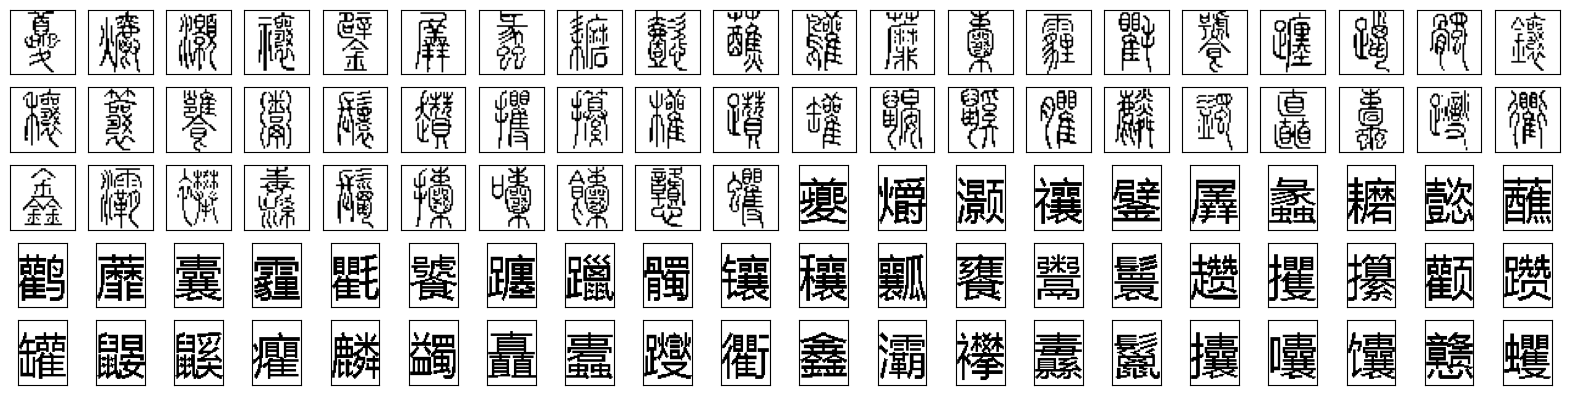

In [23]:
plt.figure(figsize=(20, 20))
counter = 1

for ix in range(50):

    plt.subplot(20, 20, counter)
    pat = pat_a[ix]
    plt.imshow(torch.sign(pat).reshape(40, 40), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1


for ix in range(50):

    plt.subplot(20, 20, counter)
    pat = pat_b[ix]
    plt.imshow(torch.sign(pat).reshape(53, 40), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    counter += 1


In [6]:
#attacker = GN(bam_bp, std=3.5)
#attacker = FGSM(bam_bp, eps=1.1)
#attacker = FFGSM(bam_bp, eps=2, alpha=1)
#attacker = PGD(bam_bp, eps=2, alpha=0.8, steps=20, random_start=True)

In [7]:
save_dir = 'bam_supplementary_materials'

for ix in range(1):
    
    a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes = 40*40, 400, 150, 400, 53*40
    bam_sra = BAM5Layer(a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes, mode='sra')
    bam_sra.bsra(torch.sign(pat_a), torch.sign(pat_b), epoches=100)
    filename="{}_{}".format('bam_sra', ix)
    torch.save(bam_sra.state_dict(), os.path.join(save_dir, filename))
    #bam_sra.load_state_dict(torch.load(os.path.join(save_dir, filename)))
    
    a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes = 40*40, 400, 400, 600, 53*40
    bam_same = BAM5Layer(a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes, mode='same')
    bam_same.bbp(torch.sign(pat_a), torch.sign(pat_b), epoches=20000, lr=1e-4)
    filename="{}_{}".format('bam_same', ix)
    torch.save(bam_same.state_dict(), os.path.join(save_dir, filename))
    #bam_same.load_state_dict(torch.load(os.path.join(save_dir, filename)))
    
    a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes = 40*40, 400, 400, 600, 53*40
    bam_diff = BAM5Layer( a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes, mode='diff')
    bam_diff.bbp(torch.sign(pat_a), torch.sign(pat_b), epoches=20000, lr=1e-4)
    filename="{}_{}".format('bam_diff', ix)
    torch.save(bam_diff.state_dict(), os.path.join(save_dir, filename))
    #bam_diff.load_state_dict(torch.load(os.path.join(save_dir, filename)))


    a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes = 40*40, 400, 400, 600, 53*40
    bam_orth = BAM5Layer( a_vnodes, h1_nodes, h2_nodes, h3_nodes, b_vnodes, mode='orth')
    bam_orth.bbp(torch.sign(pat_a), torch.sign(pat_b), epoches=20000, lr=1e-4)
    filename="{}_{}".format('bam_orth', ix)
    torch.save(bam_orth.state_dict(), os.path.join(save_dir, filename))
    #bam_orth.load_state_dict(torch.load(os.path.join(save_dir, filename)))
    

Epoch: 1 Loss A: 0.8539994603420757 Loss B: 0.8965987329033408
Grad Loss A:  0.27691859229230437 Grad Loss B:  0.2547984586209917
Pred Loss: 2.5361330188679245
Epoch: 2 Loss A: 0.6334242000753947 Loss B: 0.682465708656205
Grad Loss A:  0.9229493605528327 Grad Loss B:  0.9272048961379541
Pred Loss: 0.014121698113207546
Epoch: 3 Loss A: 0.6184993229838517 Loss B: 0.6658596282845447
Grad Loss A:  0.9375831095292382 Grad Loss B:  0.9480313555591618
Pred Loss: 0.0032915094339622643
Epoch: 4 Loss A: 0.6093888339478288 Loss B: 0.6562843202638632
Grad Loss A:  0.9419267447172125 Grad Loss B:  0.9569843612811942
Pred Loss: 0.0009556603773584906
Epoch: 5 Loss A: 0.6030326602968231 Loss B: 0.6493855364277562
Grad Loss A:  0.9442876331731006 Grad Loss B:  0.9625085253820126
Pred Loss: 0.0005273584905660377
Epoch: 6 Loss A: 0.5983118855818904 Loss B: 0.6443883045345714
Grad Loss A:  0.9455706852288212 Grad Loss B:  0.9661129590337562
Pred Loss: 0.00021320754716981134
Epoch: 7 Loss A: 0.594743739054

-------------------------------------------------------
Epoch :  30 Loss A:  0.5670651465519512 Loss B :  0.6710103361719798
Loss Grad A :  0.32994266214515167 Loss Grad B :  0.27997297708034613
Orth Loss :  12.060959140719575
Prediction Loss :  1.6931688679245283
-------------------------------------------------------
-------------------------------------------------------
Epoch :  31 Loss A:  0.5606333406629627 Loss B :  0.6663118542271036
Loss Grad A :  0.33966419147383525 Loss Grad B :  0.2777057299957502
Orth Loss :  12.240658960733157
Prediction Loss :  1.684116037735849
-------------------------------------------------------
-------------------------------------------------------
Epoch :  32 Loss A:  0.5543197887785749 Loss B :  0.6620077536564754
Loss Grad A :  0.3478172506336354 Loss Grad B :  0.27433197234911566
Orth Loss :  12.39363277511001
Prediction Loss :  1.6817556603773585
-------------------------------------------------------
-----------------------------------------

-------------------------------------------------------
Epoch :  61 Loss A:  0.48408271510400225 Loss B :  0.6320271706965171
Loss Grad A :  0.3561585169885209 Loss Grad B :  0.22835394466207842
Orth Loss :  13.405733058212464
Prediction Loss :  1.6343867924528301
-------------------------------------------------------
-------------------------------------------------------
Epoch :  62 Loss A:  0.48366611845880286 Loss B :  0.631643873444828
Loss Grad A :  0.3556863768054608 Loss Grad B :  0.22764365000802678
Orth Loss :  13.40874857221765
Prediction Loss :  1.6321896226415094
-------------------------------------------------------
-------------------------------------------------------
Epoch :  63 Loss A:  0.4833122270116144 Loss B :  0.631303033980424
Loss Grad A :  0.35534941035942935 Loss Grad B :  0.22704532344758563
Orth Loss :  13.412194223746976
Prediction Loss :  1.631740566037736
-------------------------------------------------------
-----------------------------------------

-------------------------------------------------------
Epoch :  89 Loss A:  0.4781902686748921 Loss B :  0.6271549607559516
Loss Grad A :  0.3551592334895814 Loss Grad B :  0.22417195999199502
Orth Loss :  13.57075887002506
Prediction Loss :  1.617977358490566
-------------------------------------------------------
-------------------------------------------------------
Epoch :  90 Loss A:  0.47797284333973655 Loss B :  0.6269708092852069
Loss Grad A :  0.35515419453231545 Loss Grad B :  0.2241148212330831
Orth Loss :  13.580835839474831
Prediction Loss :  1.6178132075471698
-------------------------------------------------------
-------------------------------------------------------
Epoch :  91 Loss A:  0.4777431225494329 Loss B :  0.626779964244653
Loss Grad A :  0.35513165041501643 Loss Grad B :  0.2240554631423498
Orth Loss :  13.59150257964432
Prediction Loss :  1.616909433962264
-------------------------------------------------------
--------------------------------------------

-------------------------------------------------------
Epoch :  117 Loss A:  0.46825916687155306 Loss B :  0.617713819237411
Loss Grad A :  0.35207013312712443 Loss Grad B :  0.21921684468309874
Orth Loss :  14.24048353197982
Prediction Loss :  1.5828877358490567
-------------------------------------------------------
-------------------------------------------------------
Epoch :  118 Loss A:  0.46778964243009297 Loss B :  0.6171618700018572
Loss Grad A :  0.3519707375624472 Loss Grad B :  0.21895801455031635
Orth Loss :  14.287039970496556
Prediction Loss :  1.5803745283018866
-------------------------------------------------------
-------------------------------------------------------
Epoch :  119 Loss A:  0.4673132995808926 Loss B :  0.616589594011454
Loss Grad A :  0.3518766680025244 Loss Grad B :  0.21869199802067263
Orth Loss :  14.335749341614633
Prediction Loss :  1.578277358490566
-------------------------------------------------------
--------------------------------------

-------------------------------------------------------
Epoch :  146 Loss A:  0.4529745500755518 Loss B :  0.5933501373956755
Loss Grad A :  0.3529229294130427 Loss Grad B :  0.21198884473469812
Orth Loss :  16.699780462595278
Prediction Loss :  1.4912943396226415
-------------------------------------------------------
-------------------------------------------------------
Epoch :  147 Loss A:  0.4523831478354147 Loss B :  0.5921951191239913
Loss Grad A :  0.3530275710224843 Loss Grad B :  0.21181917375148615
Orth Loss :  16.83184328474701
Prediction Loss :  1.4869622641509435
-------------------------------------------------------
-------------------------------------------------------
Epoch :  148 Loss A:  0.4517881795515035 Loss B :  0.5910220529621041
Loss Grad A :  0.3531359842703336 Loss Grad B :  0.21166181096718148
Orth Loss :  16.967298171150738
Prediction Loss :  1.4833943396226414
-------------------------------------------------------
--------------------------------------

-------------------------------------------------------
Epoch :  176 Loss A:  0.4334911264552262 Loss B :  0.5536321625010896
Loss Grad A :  0.3581434662889644 Loss Grad B :  0.21325664298648628
Orth Loss :  21.88470242209467
Prediction Loss :  1.3750103773584907
-------------------------------------------------------
-------------------------------------------------------
Epoch :  177 Loss A:  0.4327581396235104 Loss B :  0.5521651239799038
Loss Grad A :  0.3583720973942187 Loss Grad B :  0.21341834970932005
Orth Loss :  22.087153352842265
Prediction Loss :  1.3703150943396225
-------------------------------------------------------
-------------------------------------------------------
Epoch :  178 Loss A:  0.4320179900005532 Loss B :  0.5506885375683638
Loss Grad A :  0.35859971540410485 Loss Grad B :  0.213578475807751
Orth Loss :  22.290684730246305
Prediction Loss :  1.366761320754717
-------------------------------------------------------
----------------------------------------

-------------------------------------------------------
Epoch :  206 Loss A:  0.40926840228174627 Loss B :  0.5073476550664251
Loss Grad A :  0.36565939908587913 Loss Grad B :  0.22060356087926947
Orth Loss :  28.420197990178167
Prediction Loss :  1.2304132075471697
-------------------------------------------------------
-------------------------------------------------------
Epoch :  207 Loss A:  0.4084170043973609 Loss B :  0.5057492838653934
Loss Grad A :  0.3659817490618682 Loss Grad B :  0.22095659008377047
Orth Loss :  28.6546903294594
Prediction Loss :  1.225243396226415
-------------------------------------------------------
-------------------------------------------------------
Epoch :  208 Loss A:  0.4075618895407846 Loss B :  0.5041480117025378
Loss Grad A :  0.36630387254207086 Loss Grad B :  0.22131616089409673
Orth Loss :  28.890245164726302
Prediction Loss :  1.2201990566037737
-------------------------------------------------------
-------------------------------------

-------------------------------------------------------
Epoch :  234 Loss A:  0.3846910530566502 Loss B :  0.4622811857907271
Loss Grad A :  0.37597445446315036 Loss Grad B :  0.23334241397621314
Orth Loss :  35.36949424693574
Prediction Loss :  1.0906245283018867
-------------------------------------------------------
-------------------------------------------------------
Epoch :  235 Loss A:  0.38379387724204 Loss B :  0.4606860126286643
Loss Grad A :  0.37640743579862596 Loss Grad B :  0.23393958274661522
Orth Loss :  35.62957710576478
Prediction Loss :  1.0858415094339622
-------------------------------------------------------
-------------------------------------------------------
Epoch :  236 Loss A:  0.38289411669029755 Loss B :  0.45909200388627924
Loss Grad A :  0.3768414063078191 Loss Grad B :  0.23454714244326116
Orth Loss :  35.890133144330456
Prediction Loss :  1.080395283018868
-------------------------------------------------------
--------------------------------------

-------------------------------------------------------
Epoch :  264 Loss A:  0.35716639362456715 Loss B :  0.41437349890975894
Loss Grad A :  0.39042782268741355 Loss Grad B :  0.2542111285458033
Orth Loss :  43.30318257207079
Prediction Loss :  0.9516556603773585
-------------------------------------------------------
-------------------------------------------------------
Epoch :  265 Loss A:  0.3562281822770032 Loss B :  0.41277019790395564
Loss Grad A :  0.3909522402500986 Loss Grad B :  0.2549768037080958
Orth Loss :  43.57143025459369
Prediction Loss :  0.9462481132075472
-------------------------------------------------------
-------------------------------------------------------
Epoch :  266 Loss A:  0.3552879674319431 Loss B :  0.41116585712599696
Loss Grad A :  0.3914766837351503 Loss Grad B :  0.2557488084989438
Orth Loss :  43.839925133343634
Prediction Loss :  0.941795283018868
-------------------------------------------------------
--------------------------------------

-------------------------------------------------------
Epoch :  292 Loss A:  0.33071011401084566 Loss B :  0.3698863117684411
Loss Grad A :  0.40627800830363325 Loss Grad B :  0.2782068668684794
Orth Loss :  50.94326834643516
Prediction Loss :  0.8137518867924528
-------------------------------------------------------
-------------------------------------------------------
Epoch :  293 Loss A:  0.32976036608042536 Loss B :  0.3683202601034334
Loss Grad A :  0.4068891917880563 Loss Grad B :  0.2791421457892407
Orth Loss :  51.22193351853028
Prediction Loss :  0.8086471698113207
-------------------------------------------------------
-------------------------------------------------------
Epoch :  294 Loss A:  0.32881010756328294 Loss B :  0.3667551455873467
Loss Grad A :  0.40750296806467845 Loss Grad B :  0.28008034879082805
Orth Loss :  51.50104796683644
Prediction Loss :  0.8043415094339623
-------------------------------------------------------
-------------------------------------

-------------------------------------------------------
Epoch :  322 Loss A:  0.302300121510177 Loss B :  0.32410533377880785
Loss Grad A :  0.42638281674681877 Loss Grad B :  0.30946541371787345
Orth Loss :  59.507813067201184
Prediction Loss :  0.6753990566037735
-------------------------------------------------------
-------------------------------------------------------
Epoch :  323 Loss A:  0.3013566165116981 Loss B :  0.322637642927537
Loss Grad A :  0.42711232165847823 Loss Grad B :  0.31064027600390587
Orth Loss :  59.79949723694046
Prediction Loss :  0.6715330188679245
-------------------------------------------------------
-------------------------------------------------------
Epoch :  324 Loss A:  0.30041366320871493 Loss B :  0.32117389302850424
Loss Grad A :  0.42784616991405544 Loss Grad B :  0.31182309326891794
Orth Loss :  60.09143514618087
Prediction Loss :  0.6672801886792452
-------------------------------------------------------
-----------------------------------

-------------------------------------------------------
Epoch :  353 Loss A:  0.2732249909544086 Loss B :  0.28034785378471416
Loss Grad A :  0.45088648355022237 Loss Grad B :  0.34904433485817693
Orth Loss :  68.60949185818797
Prediction Loss :  0.5328518867924528
-------------------------------------------------------
-------------------------------------------------------
Epoch :  354 Loss A:  0.27229015715552685 Loss B :  0.27898775390656894
Loss Grad A :  0.45173519273771645 Loss Grad B :  0.3504181184734367
Orth Loss :  68.9036495322625
Prediction Loss :  0.5291028301886792
-------------------------------------------------------
-------------------------------------------------------
Epoch :  355 Loss A:  0.2713552476210913 Loss B :  0.27762987430987524
Loss Grad A :  0.45258668818755127 Loss Grad B :  0.35179753944068354
Orth Loss :  69.19780286193617
Prediction Loss :  0.5253773584905661
-------------------------------------------------------
-----------------------------------

-------------------------------------------------------
Epoch :  381 Loss A:  0.2472459129961574 Loss B :  0.2433012729206618
Loss Grad A :  0.4761993205472513 Loss Grad B :  0.39023018049559355
Orth Loss :  76.85919086358903
Prediction Loss :  0.4100169811320755
-------------------------------------------------------
-------------------------------------------------------
Epoch :  382 Loss A:  0.24632848816450847 Loss B :  0.24201621751075097
Loss Grad A :  0.47716794578489297 Loss Grad B :  0.3918048672862606
Orth Loss :  77.15495400872933
Prediction Loss :  0.4065915094339623
-------------------------------------------------------
-------------------------------------------------------
Epoch :  383 Loss A:  0.24541133521740074 Loss B :  0.24073381456207857
Loss Grad A :  0.4781399704458267 Loss Grad B :  0.39338721973367086
Orth Loss :  77.4508601157662
Prediction Loss :  0.40256415094339626
-------------------------------------------------------
------------------------------------

-------------------------------------------------------
Epoch :  409 Loss A:  0.2217132866082714 Loss B :  0.2084180800710714
Loss Grad A :  0.5047758789402274 Loss Grad B :  0.43791913407967376
Orth Loss :  85.20602972031656
Prediction Loss :  0.2918094339622641
-------------------------------------------------------
-------------------------------------------------------
Epoch :  410 Loss A:  0.22080988890109507 Loss B :  0.20720981592167584
Loss Grad A :  0.5058635202567052 Loss Grad B :  0.4397688064269735
Orth Loss :  85.50636086257647
Prediction Loss :  0.28838679245283017
-------------------------------------------------------
-------------------------------------------------------
Epoch :  411 Loss A:  0.2199069416447612 Loss B :  0.20600381964644374
Loss Grad A :  0.5069558652994987 Loss Grad B :  0.441628951238078
Orth Loss :  85.8067995860473
Prediction Loss :  0.2841990566037736
-------------------------------------------------------
----------------------------------------

-------------------------------------------------------
Epoch :  437 Loss A:  0.19660846840374196 Loss B :  0.175402014322686
Loss Grad A :  0.5370249533014151 Loss Grad B :  0.4938660299591362
Orth Loss :  93.64247545560434
Prediction Loss :  0.19322358490566038
-------------------------------------------------------
-------------------------------------------------------
Epoch :  438 Loss A:  0.19571834083380096 Loss B :  0.17424986208900123
Loss Grad A :  0.5382454231997483 Loss Grad B :  0.4960359929260453
Orth Loss :  93.94388292913916
Prediction Loss :  0.1895754716981132
-------------------------------------------------------
-------------------------------------------------------
Epoch :  439 Loss A:  0.19482891463728927 Loss B :  0.17309921118536734
Loss Grad A :  0.5394717490165045 Loss Grad B :  0.49821832055769105
Orth Loss :  94.24520554672898
Prediction Loss :  0.18609150943396227
-------------------------------------------------------
------------------------------------

-------------------------------------------------------
Epoch :  466 Loss A:  0.17099011294018635 Loss B :  0.14277721168016372
Loss Grad A :  0.5747060290016378 Loss Grad B :  0.5618757793190896
Orth Loss :  102.31866087006901
Prediction Loss :  0.11703301886792453
-------------------------------------------------------
-------------------------------------------------------
Epoch :  467 Loss A:  0.17011243844082627 Loss B :  0.1416830496662178
Loss Grad A :  0.5760926127288073 Loss Grad B :  0.5644148794158632
Orth Loss :  102.61350344978436
Prediction Loss :  0.1144877358490566
-------------------------------------------------------
-------------------------------------------------------
Epoch :  468 Loss A:  0.16923514203700246 Loss B :  0.14059117877748747
Loss Grad A :  0.5774855810209428 Loss Grad B :  0.5669672482004382
Orth Loss :  102.90786941384955
Prediction Loss :  0.1121443396226415
-------------------------------------------------------
----------------------------------

-------------------------------------------------------
Epoch :  496 Loss A:  0.1447785112752788 Loss B :  0.11118413649198125
Loss Grad A :  0.6191325049559384 Loss Grad B :  0.6437495587857233
Orth Loss :  110.86061303046435
Prediction Loss :  0.06424905660377359
-------------------------------------------------------
-------------------------------------------------------
Epoch :  497 Loss A:  0.14391181278079346 Loss B :  0.1101806175904852
Loss Grad A :  0.6207239898923727 Loss Grad B :  0.6466521613982209
Orth Loss :  111.13039398587259
Prediction Loss :  0.06322075471698113
-------------------------------------------------------
-------------------------------------------------------
Epoch :  498 Loss A:  0.14304588701480092 Loss B :  0.10918066068928348
Loss Grad A :  0.6223233434981892 Loss Grad B :  0.6495628139346188
Orth Loss :  111.39889277742606
Prediction Loss :  0.06204245283018868
-------------------------------------------------------
---------------------------------

-------------------------------------------------------
Epoch :  525 Loss A:  0.11995746184715769 Loss B :  0.0835531470002216
Loss Grad A :  0.6684046354978384 Loss Grad B :  0.729489418959731
Orth Loss :  118.02542965591967
Prediction Loss :  0.033010377358490564
-------------------------------------------------------
-------------------------------------------------------
Epoch :  526 Loss A:  0.11911460316263031 Loss B :  0.0826549788178184
Loss Grad A :  0.670221431638802 Loss Grad B :  0.7324264190234382
Orth Loss :  118.24252964905162
Prediction Loss :  0.03242075471698113
-------------------------------------------------------
-------------------------------------------------------
Epoch :  527 Loss A:  0.1182728276229495 Loss B :  0.08176036946628798
Loss Grad A :  0.6720464756806748 Loss Grad B :  0.7353560488029396
Orth Loss :  118.45727700621521
Prediction Loss :  0.03178207547169811
-------------------------------------------------------
-----------------------------------

-------------------------------------------------------
Epoch :  553 Loss A:  0.09681585630074738 Loss B :  0.05975012018979003
Loss Grad A :  0.7223154965839811 Loss Grad B :  0.8076188703759739
Orth Loss :  123.1690224657774
Prediction Loss :  0.015564150943396225
-------------------------------------------------------
-------------------------------------------------------
Epoch :  554 Loss A:  0.0960091691710624 Loss B :  0.05895250685761549
Loss Grad A :  0.7243525925810395 Loss Grad B :  0.8102001858989334
Orth Loss :  123.31634260367905
Prediction Loss :  0.01536320754716981
-------------------------------------------------------
-------------------------------------------------------
Epoch :  555 Loss A:  0.0952039637781404 Loss B :  0.05815858409579023
Loss Grad A :  0.7263966945531817 Loss Grad B :  0.8127629163752471
Orth Loss :  123.46121878950171
Prediction Loss :  0.014899056603773586
-------------------------------------------------------
--------------------------------

-------------------------------------------------------
Epoch :  584 Loss A:  0.07323529013047234 Loss B :  0.038948523628088726
Loss Grad A :  0.785492322661626 Loss Grad B :  0.8761872546846928
Orth Loss :  126.78217525668283
Prediction Loss :  0.006500943396226415
-------------------------------------------------------
-------------------------------------------------------
Epoch :  585 Loss A:  0.07262311166362996 Loss B :  0.03831122304675653
Loss Grad A :  0.7877685807319845 Loss Grad B :  0.8776427257704481
Orth Loss :  126.85244990301587
Prediction Loss :  0.006313207547169811
-------------------------------------------------------
-------------------------------------------------------
Epoch :  586 Loss A:  0.0719825932624799 Loss B :  0.03765877659988041
Loss Grad A :  0.7899604687070934 Loss Grad B :  0.8795523795718353
Orth Loss :  126.92083881657868
Prediction Loss :  0.0061
-------------------------------------------------------
-------------------------------------------

-------------------------------------------------------
Epoch :  615 Loss A:  0.05336961719471428 Loss B :  0.02403982743255188
Loss Grad A :  0.8473172095854248 Loss Grad B :  0.9227530641551405
Orth Loss :  128.44306932104715
Prediction Loss :  0.0018764150943396227
-------------------------------------------------------
-------------------------------------------------------
Epoch :  616 Loss A:  0.05296651637880945 Loss B :  0.02366300815807937
Loss Grad A :  0.8495840413585042 Loss Grad B :  0.9257267493432855
Orth Loss :  128.46982131466794
Prediction Loss :  0.001788679245283019
-------------------------------------------------------
-------------------------------------------------------
Epoch :  617 Loss A:  0.052345240316620655 Loss B :  0.023190368206764914
Loss Grad A :  0.8513292831829538 Loss Grad B :  0.9263601238425082
Orth Loss :  128.4915718175951
Prediction Loss :  0.001688679245283019
-------------------------------------------------------
--------------------------

-------------------------------------------------------
Epoch :  643 Loss A:  0.03913221613126175 Loss B :  0.015652129112928324
Loss Grad A :  0.8944223570591084 Loss Grad B :  0.9536758186878803
Orth Loss :  129.0302599362736
Prediction Loss :  0.0008754716981132076
-------------------------------------------------------
-------------------------------------------------------
Epoch :  644 Loss A:  0.0384635514544199 Loss B :  0.015253708031221582
Loss Grad A :  0.8953630244622834 Loss Grad B :  0.9538013710530839
Orth Loss :  129.01582280111896
Prediction Loss :  0.0008754716981132076
-------------------------------------------------------
-------------------------------------------------------
Epoch :  645 Loss A:  0.038284217305378995 Loss B :  0.015138016229743603
Loss Grad A :  0.8974876825052758 Loss Grad B :  0.9556870866200664
Orth Loss :  129.00489493970008
Prediction Loss :  0.0008754716981132076
-------------------------------------------------------
-----------------------

-------------------------------------------------------
Epoch :  671 Loss A:  0.02787216527095211 Loss B :  0.010771083052782302
Loss Grad A :  0.9282558765401352 Loss Grad B :  0.9730696515970035
Orth Loss :  129.13212997785305
Prediction Loss :  0.0004
-------------------------------------------------------
-------------------------------------------------------
Epoch :  672 Loss A:  0.027631376026829305 Loss B :  0.010587805517648857
Loss Grad A :  0.9295724635941679 Loss Grad B :  0.974408067241593
Orth Loss :  129.10057005488218
Prediction Loss :  0.0004
-------------------------------------------------------
-------------------------------------------------------
Epoch :  673 Loss A:  0.027481166745181543 Loss B :  0.010499043191132127
Loss Grad A :  0.9310570901066759 Loss Grad B :  0.9753015521578661
Orth Loss :  129.06680466160458
Prediction Loss :  0.00035
-------------------------------------------------------
-------------------------------------------------------
Epoch :  

-------------------------------------------------------
Epoch :  699 Loss A:  0.01964437110957231 Loss B :  0.007770243330779905
Loss Grad A :  0.9509352539187489 Loss Grad B :  0.9836939796238232
Orth Loss :  128.49166448294267
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch :  700 Loss A:  0.01947518691513004 Loss B :  0.007524057526609666
Loss Grad A :  0.9517759512702705 Loss Grad B :  0.9773775652879589
Orth Loss :  128.5235710302967
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch :  701 Loss A:  0.019748467833221296 Loss B :  0.007591609330405581
Loss Grad A :  0.9537480207709984 Loss Grad B :  0.9867357189991965
Orth Loss :  128.56661715977663
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch :  702 L

-------------------------------------------------------
Epoch :  728 Loss A:  0.013937633921730282 Loss B :  0.004149169420105639
Loss Grad A :  0.9638539842872714 Loss Grad B :  0.9950779869349574
Orth Loss :  127.19442935164082
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch :  729 Loss A:  0.01386913998919774 Loss B :  0.003984236249398473
Loss Grad A :  0.9560624803216232 Loss Grad B :  0.9947821694773201
Orth Loss :  127.12010697704153
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch :  730 Loss A:  0.014230474677494234 Loss B :  0.0039011797809145963
Loss Grad A :  0.9645802576282735 Loss Grad B :  0.9954357381381749
Orth Loss :  127.06879405376583
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch :  73

-------------------------------------------------------
Epoch :  757 Loss A:  0.010476554039231473 Loss B :  0.003124732233885234
Loss Grad A :  0.9797390418287509 Loss Grad B :  0.9969393662262024
Orth Loss :  126.62555469005379
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  758 Loss A:  0.010157260110924448 Loss B :  0.003002629681019474
Loss Grad A :  0.9786646625751176 Loss Grad B :  0.9968515563440454
Orth Loss :  126.58287648696633
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  759 Loss A:  0.01028599726246471 Loss B :  0.003082501328348864
Loss Grad A :  0.9806091527763406 Loss Grad B :  0.9977231342627796
Orth Loss :  126.56005283257745
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  760 Loss 

-------------------------------------------------------
Epoch :  785 Loss A:  0.006837443810935168 Loss B :  0.001878616019681386
Loss Grad A :  0.9823229900907253 Loss Grad B :  0.9751379734521392
Orth Loss :  125.24067227896296
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  786 Loss A:  0.007574695215511372 Loss B :  0.002144167393270177
Loss Grad A :  0.9768639118466553 Loss Grad B :  0.9811742540866737
Orth Loss :  125.34571641268374
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  787 Loss A:  0.007230393101805193 Loss B :  0.0021729318819594472
Loss Grad A :  0.9849658225001147 Loss Grad B :  0.9893326820143846
Orth Loss :  125.39554902610062
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  788 Los

-------------------------------------------------------
Epoch :  8 Loss A:  0.933069906115548 Loss B :  0.8930377385374276
Loss Grad A :  0.008302166642003119 Loss Grad B :  -0.16434689187381024
Orth Loss :  1.759373886046711
Prediction Loss :  2.982543396226415
-------------------------------------------------------
-------------------------------------------------------
Epoch :  9 Loss A:  0.9265333839128922 Loss B :  0.8737270971526266
Loss Grad A :  0.014918353362727496 Loss Grad B :  -0.19549140347620247
Orth Loss :  2.022616051128262
Prediction Loss :  2.8946735849056604
-------------------------------------------------------
-------------------------------------------------------
Epoch :  10 Loss A:  0.9228504550414797 Loss B :  0.8542505246325078
Loss Grad A :  0.029050500609000766 Loss Grad B :  -0.22256392289297464
Orth Loss :  2.297461211720324
Prediction Loss :  2.8133830188679245
-------------------------------------------------------
--------------------------------------

-------------------------------------------------------
Epoch :  37 Loss A:  0.9495464308275937 Loss B :  0.6667213712935706
Loss Grad A :  0.3108870532895378 Loss Grad B :  -0.4026189821897212
Orth Loss :  7.341325341774466
Prediction Loss :  2.225051886792453
-------------------------------------------------------
-------------------------------------------------------
Epoch :  38 Loss A:  0.9325821372588343 Loss B :  0.6679540823503601
Loss Grad A :  0.3015779570291382 Loss Grad B :  -0.4080003054855741
Orth Loss :  7.425267613631996
Prediction Loss :  2.1994245283018867
-------------------------------------------------------
-------------------------------------------------------
Epoch :  39 Loss A:  0.9164466770403136 Loss B :  0.6689782176283448
Loss Grad A :  0.2933347150747926 Loss Grad B :  -0.4130095852198803
Orth Loss :  7.523151866048251
Prediction Loss :  2.1744443396226414
-------------------------------------------------------
--------------------------------------------

-------------------------------------------------------
Epoch :  67 Loss A:  0.6686187056981051 Loss B :  0.6641708304965407
Loss Grad A :  0.4060957012431008 Loss Grad B :  -0.5181087949119937
Orth Loss :  14.823738818050945
Prediction Loss :  1.4673933962264152
-------------------------------------------------------
-------------------------------------------------------
Epoch :  68 Loss A:  0.6607184013614916 Loss B :  0.6638498103921338
Loss Grad A :  0.41193825111144333 Loss Grad B :  -0.5234612612449989
Orth Loss :  15.166860958451025
Prediction Loss :  1.4437669811320755
-------------------------------------------------------
-------------------------------------------------------
Epoch :  69 Loss A:  0.6533414903735143 Loss B :  0.663408989098985
Loss Grad A :  0.41807034523984044 Loss Grad B :  -0.5287407648415953
Orth Loss :  15.51270795981422
Prediction Loss :  1.4190688679245285
-------------------------------------------------------
----------------------------------------

-------------------------------------------------------
Epoch :  97 Loss A:  0.5686121367325898 Loss B :  0.614164647177108
Loss Grad A :  0.551762077865513 Loss Grad B :  -0.6454482894504546
Orth Loss :  23.35252079164912
Prediction Loss :  0.9874735849056604
-------------------------------------------------------
-------------------------------------------------------
Epoch :  98 Loss A:  0.5663990898941975 Loss B :  0.6112636309609583
Loss Grad A :  0.552848851513025 Loss Grad B :  -0.6484545857857341
Orth Loss :  23.522958738319414
Prediction Loss :  0.9786188679245282
-------------------------------------------------------
-------------------------------------------------------
Epoch :  99 Loss A:  0.5642484211940587 Loss B :  0.6083037285889017
Loss Grad A :  0.5538257216665335 Loss Grad B :  -0.6513843928645991
Orth Loss :  23.68894961070076
Prediction Loss :  0.9693150943396226
-------------------------------------------------------
---------------------------------------------

-------------------------------------------------------
Epoch :  128 Loss A:  0.5269167930830845 Loss B :  0.5172624400615786
Loss Grad A :  0.5690428688317556 Loss Grad B :  -0.7220904399059377
Orth Loss :  28.04336954173271
Prediction Loss :  0.7515009433962264
-------------------------------------------------------
-------------------------------------------------------
Epoch :  129 Loss A:  0.5260649296304626 Loss B :  0.514189239421975
Loss Grad A :  0.5694871390808103 Loss Grad B :  -0.7242672705605867
Orth Loss :  28.198012456981353
Prediction Loss :  0.7444660377358491
-------------------------------------------------------
-------------------------------------------------------
Epoch :  130 Loss A:  0.5252143863812958 Loss B :  0.5111192862363853
Loss Grad A :  0.569923839044708 Loss Grad B :  -0.7264244710949701
Orth Loss :  28.35311877373793
Prediction Loss :  0.7377830188679245
-------------------------------------------------------
-----------------------------------------

-------------------------------------------------------
Epoch :  158 Loss A:  0.49940038239006834 Loss B :  0.42653424864647616
Loss Grad A :  0.5792282848067478 Loss Grad B :  -0.7791001045473849
Orth Loss :  32.89172806605265
Prediction Loss :  0.577322641509434
-------------------------------------------------------
-------------------------------------------------------
Epoch :  159 Loss A:  0.4984416136730124 Loss B :  0.42360186906440916
Loss Grad A :  0.57954876817593 Loss Grad B :  -0.780758637281956
Orth Loss :  33.0627594025805
Prediction Loss :  0.5722556603773585
-------------------------------------------------------
-------------------------------------------------------
Epoch :  160 Loss A:  0.49748162343356145 Loss B :  0.42067866002591436
Loss Grad A :  0.5798719502628704 Loss Grad B :  -0.7824062019823256
Orth Loss :  33.234472842398745
Prediction Loss :  0.5677754716981133
-------------------------------------------------------
---------------------------------------

-------------------------------------------------------
Epoch :  188 Loss A:  0.4693698700703857 Loss B :  0.34269690744592496
Loss Grad A :  0.5895563148368278 Loss Grad B :  -0.8247708035726808
Orth Loss :  38.28767693376308
Prediction Loss :  0.4599433962264151
-------------------------------------------------------
-------------------------------------------------------
Epoch :  189 Loss A:  0.4683098125686325 Loss B :  0.3400523468024685
Loss Grad A :  0.5899200013819088 Loss Grad B :  -0.8261709756701282
Orth Loss :  38.47614404410681
Prediction Loss :  0.45673584905660375
-------------------------------------------------------
-------------------------------------------------------
Epoch :  190 Loss A:  0.4672462089670107 Loss B :  0.33741779521356663
Loss Grad A :  0.5902856051424372 Loss Grad B :  -0.8275649698646768
Orth Loss :  38.665145061533806
Prediction Loss :  0.45361509433962266
-------------------------------------------------------
-----------------------------------

-------------------------------------------------------
Epoch :  216 Loss A:  0.43843734075461727 Loss B :  0.2724977446283076
Loss Grad A :  0.600615814453811 Loss Grad B :  -0.8619985183285632
Orth Loss :  43.76651103205687
Prediction Loss :  0.38148490566037735
-------------------------------------------------------
-------------------------------------------------------
Epoch :  217 Loss A:  0.43728488763900675 Loss B :  0.27013846989306917
Loss Grad A :  0.6010470713590924 Loss Grad B :  -0.8632605527836025
Orth Loss :  43.96991181870981
Prediction Loss :  0.37922075471698113
-------------------------------------------------------
-------------------------------------------------------
Epoch :  218 Loss A:  0.43612911697052426 Loss B :  0.2677893084260217
Loss Grad A :  0.6014809766365844 Loss Grad B :  -0.864518144007776
Orth Loss :  44.17384650147922
Prediction Loss :  0.3764433962264151
-------------------------------------------------------
------------------------------------

-------------------------------------------------------
Epoch :  244 Loss A:  0.4049646730048917 Loss B :  0.21025259467835977
Loss Grad A :  0.6137803466203637 Loss Grad B :  -0.8956053208261429
Orth Loss :  49.66432338360729
Prediction Loss :  0.3132594339622642
-------------------------------------------------------
-------------------------------------------------------
Epoch :  245 Loss A:  0.4037255610020074 Loss B :  0.2081763883769503
Loss Grad A :  0.614295841492656 Loss Grad B :  -0.8967365207751673
Orth Loss :  49.88272508103201
Prediction Loss :  0.3109716981132075
-------------------------------------------------------
-------------------------------------------------------
Epoch :  246 Loss A:  0.40248362688406747 Loss B :  0.2061104324378689
Loss Grad A :  0.6148146927777285 Loss Grad B :  -0.8978627940622875
Orth Loss :  50.10165813220927
Prediction Loss :  0.30845849056603775
-------------------------------------------------------
--------------------------------------

-------------------------------------------------------
Epoch :  272 Loss A:  0.3692246457129011 Loss B :  0.15605445360974518
Loss Grad A :  0.6295212393872465 Loss Grad B :  -0.9253789068576843
Orth Loss :  55.97488819893981
Prediction Loss :  0.24315094339622642
-------------------------------------------------------
-------------------------------------------------------
Epoch :  273 Loss A:  0.3679094094977254 Loss B :  0.15427190308495892
Loss Grad A :  0.6301359163170016 Loss Grad B :  -0.9263664784326221
Orth Loss :  56.207442831738504
Prediction Loss :  0.24071320754716982
-------------------------------------------------------
-------------------------------------------------------
Epoch :  274 Loss A:  0.3665916776498333 Loss B :  0.15250005615200338
Loss Grad A :  0.6307544971955698 Loss Grad B :  -0.9273484981791443
Orth Loss :  56.44046503429935
Prediction Loss :  0.2385254716981132
-------------------------------------------------------
----------------------------------

-------------------------------------------------------
Epoch :  301 Loss A:  0.3301274670233196 Loss B :  0.10874574946354844
Loss Grad A :  0.6490235315479534 Loss Grad B :  -0.9515832432171462
Orth Loss :  62.89582466137024
Prediction Loss :  0.1739754716981132
-------------------------------------------------------
-------------------------------------------------------
Epoch :  302 Loss A:  0.32874599248010955 Loss B :  0.10727776373506107
Loss Grad A :  0.649761146852596 Loss Grad B :  -0.9523898059369194
Orth Loss :  63.14040105279053
Prediction Loss :  0.1719254716981132
-------------------------------------------------------
-------------------------------------------------------
Epoch :  303 Loss A:  0.3273624699346909 Loss B :  0.10582075806024137
Loss Grad A :  0.65050334786731 Loss Grad B :  -0.9531894845390372
Orth Loss :  63.385320736182805
Prediction Loss :  0.1697254716981132
-------------------------------------------------------
--------------------------------------

-------------------------------------------------------
Epoch :  332 Loss A:  0.2864485372259673 Loss B :  0.06836579634419819
Loss Grad A :  0.6741370514069951 Loss Grad B :  -0.9733218553952584
Orth Loss :  70.60687736467709
Prediction Loss :  0.1025
-------------------------------------------------------
-------------------------------------------------------
Epoch :  333 Loss A:  0.28501366231145747 Loss B :  0.06723965967446194
Loss Grad A :  0.6750285309155316 Loss Grad B :  -0.9739093052192906
Orth Loss :  70.85880707070085
Prediction Loss :  0.1006
-------------------------------------------------------
-------------------------------------------------------
Epoch :  334 Loss A:  0.28357738199012267 Loss B :  0.06612448364467034
Loss Grad A :  0.675925360099213 Loss Grad B :  -0.9744895308096511
Orth Loss :  71.11084362051552
Prediction Loss :  0.09895
-------------------------------------------------------
-------------------------------------------------------
Epoch :  335 Lo

-------------------------------------------------------
Epoch :  362 Loss A:  0.24286186634777082 Loss B :  0.03928098153911214
Loss Grad A :  0.7033214943783237 Loss Grad B :  -0.9877519522682142
Orth Loss :  78.17218803282411
Prediction Loss :  0.04895
-------------------------------------------------------
-------------------------------------------------------
Epoch :  363 Loss A:  0.24139235319725572 Loss B :  0.038475659764762624
Loss Grad A :  0.7043860924266823 Loss Grad B :  -0.9881186855580175
Orth Loss :  78.42301011630143
Prediction Loss :  0.0477
-------------------------------------------------------
-------------------------------------------------------
Epoch :  364 Loss A:  0.2399219429112381 Loss B :  0.03768066079250658
Loss Grad A :  0.7054569937705495 Loss Grad B :  -0.9884781774369401
Orth Loss :  78.67362145473865
Prediction Loss :  0.0465
-------------------------------------------------------
-------------------------------------------------------
Epoch :  365 

-------------------------------------------------------
Epoch :  390 Loss A:  0.2014265562598049 Loss B :  0.02052684723162601
Loss Grad A :  0.7356694776840635 Loss Grad B :  -0.9954358415433596
Orth Loss :  85.06917332828009
Prediction Loss :  0.01975
-------------------------------------------------------
-------------------------------------------------------
Epoch :  391 Loss A:  0.1999376700299007 Loss B :  0.019997579949608123
Loss Grad A :  0.7369298737449875 Loss Grad B :  -0.9956193998987652
Orth Loss :  85.30855590603308
Prediction Loss :  0.01875
-------------------------------------------------------
-------------------------------------------------------
Epoch :  392 Loss A:  0.19844829984955162 Loss B :  0.019477569319657495
Loss Grad A :  0.7381982023035667 Loss Grad B :  -0.9957974433288516
Orth Loss :  85.54728900318585
Prediction Loss :  0.01825
-------------------------------------------------------
-------------------------------------------------------
Epoch :  39

-------------------------------------------------------
Epoch :  419 Loss A:  0.15996213050194824 Loss B :  0.009470644237037674
Loss Grad A :  0.7757022999743959 Loss Grad B :  -0.9974983337915337
Orth Loss :  91.35663205470533
Prediction Loss :  0.00705
-------------------------------------------------------
-------------------------------------------------------
Epoch :  420 Loss A:  0.15838932278621212 Loss B :  0.00943168437752877
Loss Grad A :  0.7767731044285381 Loss Grad B :  -0.9886322233299228
Orth Loss :  91.50281949735401
Prediction Loss :  0.00675
-------------------------------------------------------
-------------------------------------------------------
Epoch :  421 Loss A:  0.1571587489414162 Loss B :  0.009144750363542998
Loss Grad A :  0.778140080208139 Loss Grad B :  -0.9973610931697635
Orth Loss :  91.64304980677666
Prediction Loss :  0.0065
-------------------------------------------------------
-------------------------------------------------------
Epoch :  422

-------------------------------------------------------
Epoch :  449 Loss A:  0.1221980767172396 Loss B :  0.0046961183189532605
Loss Grad A :  0.8168778462199731 Loss Grad B :  -0.9974915224860652
Orth Loss :  95.54474839469412
Prediction Loss :  0.00185
-------------------------------------------------------
-------------------------------------------------------
Epoch :  450 Loss A:  0.12088501534132143 Loss B :  0.004612196645620763
Loss Grad A :  0.8182604130766817 Loss Grad B :  -0.9929988188639252
Orth Loss :  95.67953878183202
Prediction Loss :  0.00175
-------------------------------------------------------
-------------------------------------------------------
Epoch :  451 Loss A:  0.11967984999545124 Loss B :  0.004543198582724718
Loss Grad A :  0.819697417854714 Loss Grad B :  -0.990413360938771
Orth Loss :  95.80392366202216
Prediction Loss :  0.00165
-------------------------------------------------------
-------------------------------------------------------
Epoch :  4

-------------------------------------------------------
Epoch :  481 Loss A:  0.08977999231510449 Loss B :  0.0026862584135638537
Loss Grad A :  0.8663683344465426 Loss Grad B :  -0.9946597618625509
Orth Loss :  98.54799626914225
Prediction Loss :  0.0008
-------------------------------------------------------
-------------------------------------------------------
Epoch :  482 Loss A:  0.0884645011566299 Loss B :  0.002750951929589864
Loss Grad A :  0.8675019337270489 Loss Grad B :  -0.993067847743309
Orth Loss :  98.6006747076267
Prediction Loss :  0.0008
-------------------------------------------------------
-------------------------------------------------------
Epoch :  483 Loss A:  0.08737168243221283 Loss B :  0.0027430669468272214
Loss Grad A :  0.8688206253603085 Loss Grad B :  -0.9984445127895591
Orth Loss :  98.64934503779651
Prediction Loss :  0.00075
-------------------------------------------------------
-------------------------------------------------------
Epoch :  48

-------------------------------------------------------
Epoch :  512 Loss A:  0.06573762162722104 Loss B :  0.0020557885830035524
Loss Grad A :  0.9126371835420534 Loss Grad B :  -0.9950616471700655
Orth Loss :  100.06066383708159
Prediction Loss :  0.00045
-------------------------------------------------------
-------------------------------------------------------
Epoch :  513 Loss A:  0.06476644885362345 Loss B :  0.002154739518303744
Loss Grad A :  0.9136587194180718 Loss Grad B :  -0.9892713596042697
Orth Loss :  100.06173696035583
Prediction Loss :  0.00045
-------------------------------------------------------
-------------------------------------------------------
Epoch :  514 Loss A:  0.0637357003832547 Loss B :  0.0022088583175156325
Loss Grad A :  0.9146341671740902 Loss Grad B :  -0.9971284111853754
Orth Loss :  100.05258370095581
Prediction Loss :  0.00045
-------------------------------------------------------
-------------------------------------------------------
Epoc

-------------------------------------------------------
Epoch :  541 Loss A:  0.04853647908250441 Loss B :  0.0020315475525090835
Loss Grad A :  0.9464283824923523 Loss Grad B :  -0.9997112295277638
Orth Loss :  100.29824801118758
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  542 Loss A:  0.04812935494583077 Loss B :  0.00198043005090125
Loss Grad A :  0.9475251507136655 Loss Grad B :  -0.9997323792811263
Orth Loss :  100.32056632295604
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  543 Loss A:  0.04770432249165899 Loss B :  0.0019334526805644128
Loss Grad A :  0.9485835797825563 Loss Grad B :  -0.9996276408922009
Orth Loss :  100.34286891229297
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  544 Los

-------------------------------------------------------
Epoch :  572 Loss A:  0.03449513596426858 Loss B :  0.0027553701168894964
Loss Grad A :  0.9701466867054376 Loss Grad B :  -0.9964313992797099
Orth Loss :  99.43000247931408
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  573 Loss A:  0.03389036748012171 Loss B :  0.002889183927874342
Loss Grad A :  0.9704135042372112 Loss Grad B :  -0.9979863503601236
Orth Loss :  99.35603158563953
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  574 Loss A:  0.03421098205305415 Loss B :  0.002828595529218174
Loss Grad A :  0.9717268508135305 Loss Grad B :  -0.9965316927125312
Orth Loss :  99.29947829305277
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  575 Loss A

-------------------------------------------------------
Epoch :  601 Loss A:  0.02547774662905352 Loss B :  0.002533109401960252
Loss Grad A :  0.9833456886560654 Loss Grad B :  -0.9997954719404811
Orth Loss :  98.73533744182913
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  602 Loss A:  0.024975770014273372 Loss B :  0.0025343673598539674
Loss Grad A :  0.9834655241235609 Loss Grad B :  -0.9998860681151786
Orth Loss :  98.73267723398445
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  603 Loss A:  0.024621920362754405 Loss B :  0.0025043060514486543
Loss Grad A :  0.9837142864909785 Loss Grad B :  -0.9998477777423633
Orth Loss :  98.73269530130304
Prediction Loss :  0.0
-------------------------------------------------------
-------------------------------------------------------
Epoch :  604 Los

-------------------------------------------------------
Epoch :  1 Loss A:  1.0438673159957659 Loss B :  1.0362025007122644
Loss Grad A :  0.2048996810001848 Loss Grad B :  0.18686402383644576
Orth Loss :  5.575177193526572e-14
Prediction Loss :  4.019216037735849
-------------------------------------------------------
-------------------------------------------------------
Epoch :  2 Loss A:  1.011591917652134 Loss B :  1.0092530122086305
Loss Grad A :  0.13036405967601714 Loss Grad B :  0.11660441742776483
Orth Loss :  0.2532569140387884
Prediction Loss :  3.773398113207547
-------------------------------------------------------
-------------------------------------------------------
Epoch :  3 Loss A:  0.9817069928980081 Loss B :  0.9846000007580225
Loss Grad A :  0.061869871240365075 Loss Grad B :  0.05302018078762272
Orth Loss :  0.4802640455802773
Prediction Loss :  3.55131037735849
-------------------------------------------------------
------------------------------------------

-------------------------------------------------------
Epoch :  34 Loss A:  0.4515266694869665 Loss B :  0.603138129789165
Loss Grad A :  -0.045031905133148475 Loss Grad B :  0.04996975290350023
Orth Loss :  9.003688518518574
Prediction Loss :  1.622417924528302
-------------------------------------------------------
-------------------------------------------------------
Epoch :  35 Loss A:  0.4468598287490996 Loss B :  0.6018430709680396
Loss Grad A :  -0.04076332330616383 Loss Grad B :  0.04762508175443897
Orth Loss :  9.098762027153292
Prediction Loss :  1.620440566037736
-------------------------------------------------------
-------------------------------------------------------
Epoch :  36 Loss A:  0.44269307826262067 Loss B :  0.6006802886081284
Loss Grad A :  -0.03713008037700039 Loss Grad B :  0.04430030762926441
Orth Loss :  9.179559119666369
Prediction Loss :  1.6155547169811322
-------------------------------------------------------
--------------------------------------

-------------------------------------------------------
Epoch :  67 Loss A:  0.40337209403810775 Loss B :  0.5790193144077821
Loss Grad A :  -0.048363592379927704 Loss Grad B :  -0.0425669435926109
Orth Loss :  10.054577524009384
Prediction Loss :  1.5325764150943395
-------------------------------------------------------
-------------------------------------------------------
Epoch :  68 Loss A:  0.4026802918836837 Loss B :  0.5781089954868476
Loss Grad A :  -0.0495778440726867 Loss Grad B :  -0.04329694276395681
Orth Loss :  10.095864098893657
Prediction Loss :  1.5291103773584906
-------------------------------------------------------
-------------------------------------------------------
Epoch :  69 Loss A:  0.4019778982264287 Loss B :  0.5771760315138424
Loss Grad A :  -0.05076520027421676 Loss Grad B :  -0.04406804966379136
Orth Loss :  10.13898311792607
Prediction Loss :  1.5258330188679246
-------------------------------------------------------
--------------------------------

-------------------------------------------------------
Epoch :  100 Loss A:  0.3749142020739481 Loss B :  0.5325123791567573
Loss Grad A :  -0.07754575091078579 Loss Grad B :  -0.08819446382450062
Orth Loss :  12.746094376706349
Prediction Loss :  1.3279528301886794
-------------------------------------------------------
-------------------------------------------------------
Epoch :  101 Loss A:  0.373895907085918 Loss B :  0.5305299135368741
Loss Grad A :  -0.07802190695528066 Loss Grad B :  -0.08969748856032461
Orth Loss :  12.880274156462272
Prediction Loss :  1.322338679245283
-------------------------------------------------------
-------------------------------------------------------
Epoch :  102 Loss A:  0.3728703311029035 Loss B :  0.5285180552016805
Loss Grad A :  -0.07848280128701882 Loss Grad B :  -0.09119785257312017
Orth Loss :  13.017536527023882
Prediction Loss :  1.3150349056603774
-------------------------------------------------------
------------------------------

-------------------------------------------------------
Epoch :  132 Loss A:  0.33937152709920726 Loss B :  0.45876775396496083
Loss Grad A :  -0.09075441044770571 Loss Grad B :  -0.1354174870092873
Orth Loss :  18.287650763022523
Prediction Loss :  1.0830735849056603
-------------------------------------------------------
-------------------------------------------------------
Epoch :  133 Loss A:  0.33819031957291185 Loss B :  0.4562357345577055
Loss Grad A :  -0.09120947422000056 Loss Grad B :  -0.13685480288643523
Orth Loss :  18.49331686908302
Prediction Loss :  1.0763943396226414
-------------------------------------------------------
-------------------------------------------------------
Epoch :  134 Loss A:  0.337006794358764 Loss B :  0.45369587749238444
Loss Grad A :  -0.09166910585233813 Loss Grad B :  -0.1382825003183613
Orth Loss :  18.7004848787929
Prediction Loss :  1.0685745283018868
-------------------------------------------------------
------------------------------

-------------------------------------------------------
Epoch :  165 Loss A:  0.2996513593609445 Loss B :  0.37411935061037094
Loss Grad A :  -0.10782620015443975 Loss Grad B :  -0.17356738047236298
Orth Loss :  25.670922455200646
Prediction Loss :  0.8388962264150943
-------------------------------------------------------
-------------------------------------------------------
Epoch :  166 Loss A:  0.29843462338993293 Loss B :  0.3716074358011106
Loss Grad A :  -0.10842554637457955 Loss Grad B :  -0.1743990548856928
Orth Loss :  25.906865147591432
Prediction Loss :  0.832722641509434
-------------------------------------------------------
-------------------------------------------------------
Epoch :  167 Loss A:  0.29721764053730765 Loss B :  0.36910283801759214
Loss Grad A :  -0.10903009605225705 Loss Grad B :  -0.1752126076086703
Orth Loss :  26.143125393200876
Prediction Loss :  0.8251792452830189
-------------------------------------------------------
---------------------------

-------------------------------------------------------
Epoch :  197 Loss A:  0.26078765595374276 Loss B :  0.2981588093377167
Loss Grad A :  -0.127933062566173 Loss Grad B :  -0.19377355056448906
Orth Loss :  33.26936914452589
Prediction Loss :  0.6325518867924529
-------------------------------------------------------
-------------------------------------------------------
Epoch :  198 Loss A:  0.25958259811437845 Loss B :  0.2959458479736648
Loss Grad A :  -0.12857680503478602 Loss Grad B :  -0.19427433704093042
Orth Loss :  33.50566240196548
Prediction Loss :  0.6256160377358491
-------------------------------------------------------
-------------------------------------------------------
Epoch :  199 Loss A:  0.25837858768281086 Loss B :  0.29374279466104203
Loss Grad A :  -0.12922206537071626 Loss Grad B :  -0.1947711821593645
Orth Loss :  33.74177813988156
Prediction Loss :  0.619793396226415
-------------------------------------------------------
-------------------------------

-------------------------------------------------------
Epoch :  223 Loss A:  0.22988172661438144 Loss B :  0.24389329588640654
Loss Grad A :  -0.14491183670511604 Loss Grad B :  -0.20555237360474238
Orth Loss :  39.34933834658351
Prediction Loss :  0.4775952830188679
-------------------------------------------------------
-------------------------------------------------------
Epoch :  224 Loss A:  0.22871441107618276 Loss B :  0.2419447544174834
Loss Grad A :  -0.14556194914162202 Loss Grad B :  -0.205945795463822
Orth Loss :  39.58037928446622
Prediction Loss :  0.4717867924528302
-------------------------------------------------------
-------------------------------------------------------
Epoch :  225 Loss A:  0.22754898141627597 Loss B :  0.24000657881863305
Loss Grad A :  -0.14621212508093012 Loss Grad B :  -0.20633458511468616
Orth Loss :  39.81119741152982
Prediction Loss :  0.4660518867924528
-------------------------------------------------------
----------------------------

-------------------------------------------------------
Epoch :  256 Loss A:  0.19254761231932463 Loss B :  0.1850724275953582
Loss Grad A :  -0.1656159529055827 Loss Grad B :  -0.2158846164140854
Orth Loss :  46.83593742307079
Prediction Loss :  0.30609339622641507
-------------------------------------------------------
-------------------------------------------------------
Epoch :  257 Loss A:  0.19146109760518054 Loss B :  0.183464269788375
Loss Grad A :  -0.16620444181657695 Loss Grad B :  -0.21613946109599944
Orth Loss :  47.05753356835122
Prediction Loss :  0.30121603773584904
-------------------------------------------------------
-------------------------------------------------------
Epoch :  258 Loss A:  0.1903775544312993 Loss B :  0.1818660927609385
Loss Grad A :  -0.16679039383550187 Loss Grad B :  -0.216392605969681
Orth Loss :  47.27876784315852
Prediction Loss :  0.29728962264150943
-------------------------------------------------------
-------------------------------

-------------------------------------------------------
Epoch :  282 Loss A:  0.16529342302074218 Loss B :  0.14640623919619344
Loss Grad A :  -0.180147565521391 Loss Grad B :  -0.22202209737000747
Orth Loss :  52.47115957895419
Prediction Loss :  0.20035377358490566
-------------------------------------------------------
-------------------------------------------------------
Epoch :  283 Loss A:  0.16428796161069426 Loss B :  0.14504533183231746
Loss Grad A :  -0.1806768231691464 Loss Grad B :  -0.22223588079124226
Orth Loss :  52.6823178541077
Prediction Loss :  0.19718018867924528
-------------------------------------------------------
-------------------------------------------------------
Epoch :  284 Loss A:  0.16328582978506093 Loss B :  0.1436934369651669
Loss Grad A :  -0.18120437367893846 Loss Grad B :  -0.22244788598304893
Orth Loss :  52.89304006847981
Prediction Loss :  0.19340849056603773
-------------------------------------------------------
---------------------------

-------------------------------------------------------
Epoch :  308 Loss A:  0.14028962467958103 Loss B :  0.11387979930908897
Loss Grad A :  -0.19319158719316293 Loss Grad B :  -0.22687511515571285
Orth Loss :  57.8155580314163
Prediction Loss :  0.12344245283018868
-------------------------------------------------------
-------------------------------------------------------
Epoch :  309 Loss A:  0.13937744059207843 Loss B :  0.11274471318173644
Loss Grad A :  -0.19365463836640615 Loss Grad B :  -0.2270244102098291
Orth Loss :  58.01488463657535
Prediction Loss :  0.12019716981132075
-------------------------------------------------------
-------------------------------------------------------
Epoch :  310 Loss A:  0.1384690801710318 Loss B :  0.11161804392234716
Loss Grad A :  -0.19411424865911953 Loss Grad B :  -0.22717008202096764
Orth Loss :  58.213734765661826
Prediction Loss :  0.11822924528301887
-------------------------------------------------------
------------------------

-------------------------------------------------------
Epoch :  334 Loss A:  0.11784323368867222 Loss B :  0.08705465746419068
Loss Grad A :  -0.2041982907435265 Loss Grad B :  -0.2292625389393232
Orth Loss :  62.836312924622675
Prediction Loss :  0.0706877358490566
-------------------------------------------------------
-------------------------------------------------------
Epoch :  335 Loss A:  0.117033381210721 Loss B :  0.0861319021746459
Loss Grad A :  -0.20458505782746475 Loss Grad B :  -0.2292754163761922
Orth Loss :  63.022310812459104
Prediction Loss :  0.06928396226415094
-------------------------------------------------------
-------------------------------------------------------
Epoch :  336 Loss A:  0.11622750533528406 Loss B :  0.08521696729021819
Loss Grad A :  -0.20496928422457603 Loss Grad B :  -0.22928127644828258
Orth Loss :  63.207745581002506
Prediction Loss :  0.06828113207547169
-------------------------------------------------------
--------------------------

-------------------------------------------------------
Epoch :  366 Loss A:  0.09388193907983514 Loss B :  0.061212647154964134
Loss Grad A :  -0.21508131831982147 Loss Grad B :  -0.22654343954021994
Orth Loss :  68.48877148806132
Prediction Loss :  0.03300660377358491
-------------------------------------------------------
-------------------------------------------------------
Epoch :  367 Loss A:  0.09319718786126907 Loss B :  0.06051998280268205
Loss Grad A :  -0.2153712505352108 Loss Grad B :  -0.22637367063214967
Orth Loss :  68.65483904252889
Prediction Loss :  0.03222924528301887
-------------------------------------------------------
-------------------------------------------------------
Epoch :  368 Loss A:  0.09251623713935506 Loss B :  0.05983373995062768
Loss Grad A :  -0.21565855257484415 Loss Grad B :  -0.22619995201724166
Orth Loss :  68.8202372811307
Prediction Loss :  0.031616037735849055
-------------------------------------------------------
----------------------

-------------------------------------------------------
Epoch :  399 Loss A:  0.07323990135634388 Loss B :  0.041496116760483696
Loss Grad A :  -0.2232803600388231 Loss Grad B :  -0.21908716758988583
Orth Loss :  73.61348021513268
Prediction Loss :  0.014725471698113207
-------------------------------------------------------
-------------------------------------------------------
Epoch :  400 Loss A:  0.07267544456252496 Loss B :  0.040991861255947046
Loss Grad A :  -0.2234862943011432 Loss Grad B :  -0.21880609773152396
Orth Loss :  73.75739585797811
Prediction Loss :  0.014162264150943397
-------------------------------------------------------
-------------------------------------------------------
Epoch :  401 Loss A:  0.07211445796656936 Loss B :  0.04049262133161958
Loss Grad A :  -0.22368994150573066 Loss Grad B :  -0.2185215724884122
Orth Loss :  73.90065157892899
Prediction Loss :  0.013736792452830188
-------------------------------------------------------
--------------------

-------------------------------------------------------
Epoch :  431 Loss A:  0.05683706838167584 Loss B :  0.02767283729988052
Loss Grad A :  -0.22874385655527732 Loss Grad B :  -0.2081025740353843
Orth Loss :  77.89632666537935
Prediction Loss :  0.0051160377358490565
-------------------------------------------------------
-------------------------------------------------------
Epoch :  432 Loss A:  0.056377385896916175 Loss B :  0.027311954768557217
Loss Grad A :  -0.22887705040532436 Loss Grad B :  -0.20768426096503237
Orth Loss :  78.01960657202204
Prediction Loss :  0.005028301886792453
-------------------------------------------------------
-------------------------------------------------------
Epoch :  433 Loss A:  0.05592075958172171 Loss B :  0.0269550274595507
Loss Grad A :  -0.22900789849152062 Loss Grad B :  -0.2072608864285527
Orth Loss :  78.14225683303852
Prediction Loss :  0.004978301886792453
-------------------------------------------------------
-------------------

-------------------------------------------------------
Epoch :  463 Loss A:  0.043579460292501836 Loss B :  0.017944629931762907
Loss Grad A :  -0.23176569019408738 Loss Grad B :  -0.19213479580147935
Orth Loss :  81.53339594988924
Prediction Loss :  0.002100943396226415
-------------------------------------------------------
-------------------------------------------------------
Epoch :  464 Loss A:  0.04321125165180847 Loss B :  0.01769622730729962
Loss Grad A :  -0.23181697328770895 Loss Grad B :  -0.19155037141664838
Orth Loss :  81.63697519314275
Prediction Loss :  0.0020632075471698113
-------------------------------------------------------
-------------------------------------------------------
Epoch :  465 Loss A:  0.04284569574230903 Loss B :  0.01745087996171691
Loss Grad A :  -0.23186559312373858 Loss Grad B :  -0.1909609348958915
Orth Loss :  81.73995459503462
Prediction Loss :  0.0019632075471698114
-------------------------------------------------------
----------------

-------------------------------------------------------
Epoch :  495 Loss A:  0.03305045196905471 Loss B :  0.011378002627592315
Loss Grad A :  -0.23209991336008481 Loss Grad B :  -0.17109419400849255
Orth Loss :  84.55605877211676
Prediction Loss :  0.00045
-------------------------------------------------------
-------------------------------------------------------
Epoch :  496 Loss A:  0.0327609089604612 Loss B :  0.011214193521518277
Loss Grad A :  -0.23206719607572335 Loss Grad B :  -0.17036540649604182
Orth Loss :  84.64103311338155
Prediction Loss :  0.0004
-------------------------------------------------------
-------------------------------------------------------
Epoch :  497 Loss A:  0.03247361640061119 Loss B :  0.011052608676903655
Loss Grad A :  -0.23203187547832457 Loss Grad B :  -0.16963280312093332
Orth Loss :  84.72544907548861
Prediction Loss :  0.0004
-------------------------------------------------------
-------------------------------------------------------
Ep

-------------------------------------------------------
Epoch :  530 Loss A:  0.024173361108015927 Loss B :  0.006817377934995757
Loss Grad A :  -0.22944436705909246 Loss Grad B :  -0.14368038775227648
Orth Loss :  87.20950296693744
Prediction Loss :  0.0001
-------------------------------------------------------
-------------------------------------------------------
Epoch :  531 Loss A:  0.023955138344288057 Loss B :  0.0067179552735852615
Loss Grad A :  -0.22932467980352755 Loss Grad B :  -0.14285259035767375
Orth Loss :  87.27601983751318
Prediction Loss :  0.0001
-------------------------------------------------------
-------------------------------------------------------
Epoch :  532 Loss A:  0.023738731031458644 Loss B :  0.006619993884145457
Loss Grad A :  -0.2292027018313508 Loss Grad B :  -0.14202317310161672
Orth Loss :  87.34204608050186
Prediction Loss :  0.0001
-------------------------------------------------------
-------------------------------------------------------

-------------------------------------------------------
Epoch :  564 Loss A:  0.017701570028058545 Loss B :  0.004149231540693131
Loss Grad A :  -0.224176434399245 Loss Grad B :  -0.1150890429558003
Orth Loss :  89.20998284007585
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch :  565 Loss A:  0.017538505780993797 Loss B :  0.004089680971329179
Loss Grad A :  -0.22398694543531697 Loss Grad B :  -0.11424982933985525
Orth Loss :  89.26116341036241
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch :  566 Loss A:  0.017376866658746534 Loss B :  0.004031030297410467
Loss Grad A :  -0.2237956467307007 Loss Grad B :  -0.11341166028526076
Orth Loss :  89.31193685503894
Prediction Loss :  5e-05
-------------------------------------------------------
-------------------------------------------------------
Epoch 

In [8]:
def adv_attack(model, attacker, pat_a, pat_b):

    adv_a, adv_b = attacker.forward(pat_a, pat_b)
    adv_output_b = model.a_query_b(adv_a)
    adv_output_a = model.b_query_a(adv_b)

    input_noise_a = F.mse_loss(pat_a, adv_a)
    input_noise_b = F.mse_loss(pat_b, adv_b)

    output_noise_a = F.mse_loss(pat_a, adv_output_a)
    output_noise_b = F.mse_loss(pat_b, adv_output_b)

    print("Input Noise A: ", input_noise_a.item())
    print("Input Noise B: ", input_noise_b.item())

    print("Output Noise A: ", output_noise_a.item())
    print("Output Noise B: ", output_noise_b.item())
    
    return [input_noise_a.item(), output_noise_b.item(), input_noise_b.item(), output_noise_a.item()]
    

In [9]:
name_list = ['SRA', 'ORTH', 'SAME', 'DIFF']

In [10]:
models = [bam_sra, bam_orth, bam_same, bam_diff]

In [11]:
def cover(patterns, pixels):
    cov_pat = []
    for ix in range(len(patterns)):
        pat = patterns[ix].clone().detach()
        for iy in range(int(pixels)):
            pat[iy] = 0
        cov_pat.append(pat)
    return torch.stack(cov_pat)

In [12]:
cov_a = cover(pat_a, 800)
cov_b = cover(pat_b, 1060)

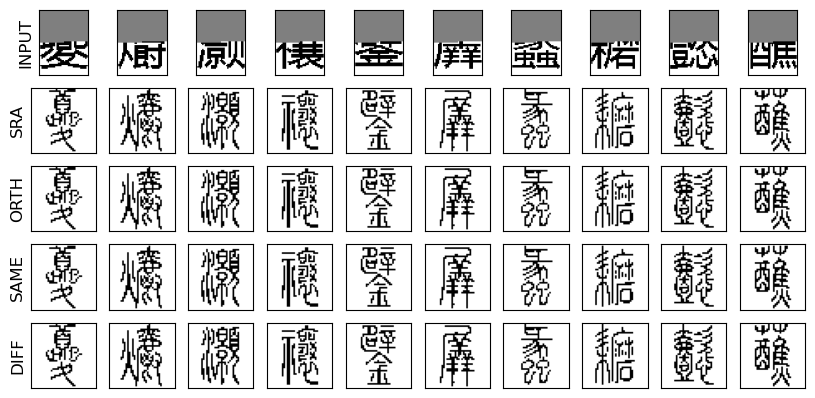

In [13]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12})
counter = 1
n_recursive = 10

ylabel = ['SRA', 'ORTH', 'SAME', 'DIFF']

for ix in range(10):

    plt.subplot(10, 10, counter)
    pat = cov_b[ix]
    plt.imshow(pat.reshape(53, 40), cmap='binary')
    
    if ix == 0:
        plt.ylabel('INPUT')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    

    counter += 1

for iy in range(4):
    for ix in range(10):

        plt.subplot(10, 10, counter)
        pat = cov_b[ix]
        res = models[iy].b_query_a(pat, n_recursive).detach().numpy()
        plt.imshow(np.sign(res).reshape(40, 40), cmap='binary')
        
        if ix == 0:
            plt.ylabel(ylabel[iy])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        counter += 1


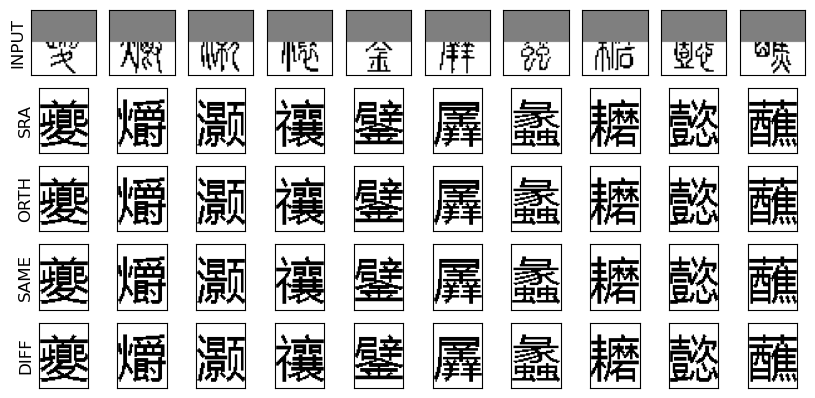

In [14]:
plt.figure(figsize=(10, 10))
counter = 1
n_recursive = 5

for ix in range(10):

    plt.subplot(10, 10, counter)
    pat = cov_a[ix]
    plt.imshow(pat.reshape(40, 40), cmap='binary')
    if ix == 0:
        plt.ylabel('INPUT')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    counter += 1


for iy in range(4):
    for ix in range(10):

        plt.subplot(10, 10, counter)
        pat = cov_a[ix]
        res = models[iy].a_query_b(pat, n_recursive).detach().numpy()
        plt.imshow(np.sign(res).reshape(53, 40), cmap='binary')
        
        if ix == 0:
            plt.ylabel(ylabel[iy])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        counter += 1

In [15]:
class GN():
    r"""
    Add Gaussian Noise.

    Arguments:
        model (nn.Module): model to attack.
        std (nn.Module): standard deviation (Default: 0.1).

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.GN(model)
        >>> adv_images = attack(images, labels)

    """
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std
        self.supported_mode = ["default"]

    def forward(self, sensory_a, sensory_b):
        r"""
        Overridden.
        """
        adv_a = sensory_a + self.std * torch.randn_like(sensory_a)
        adv_b = sensory_b + self.std * torch.randn_like(sensory_b)

        return adv_a, adv_b

In [16]:
attacker = GN(std=6)

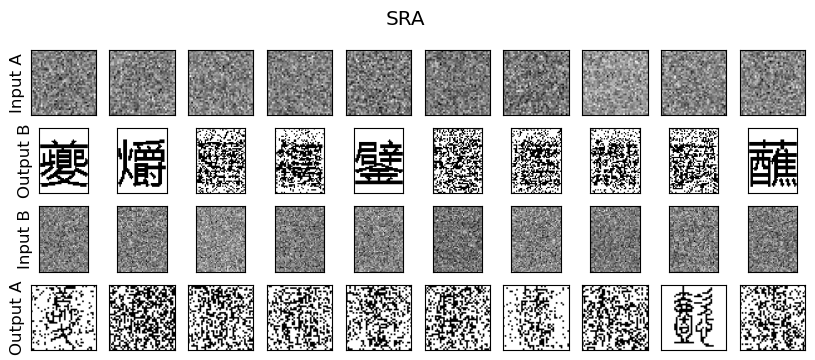

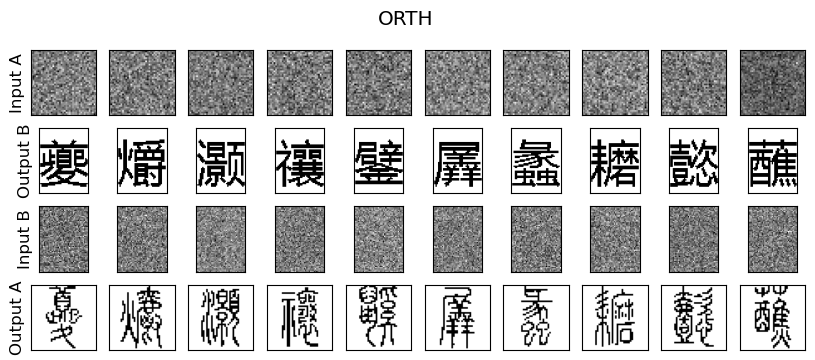

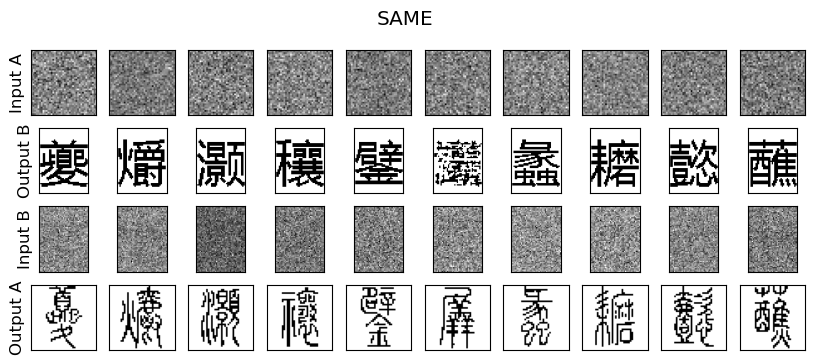

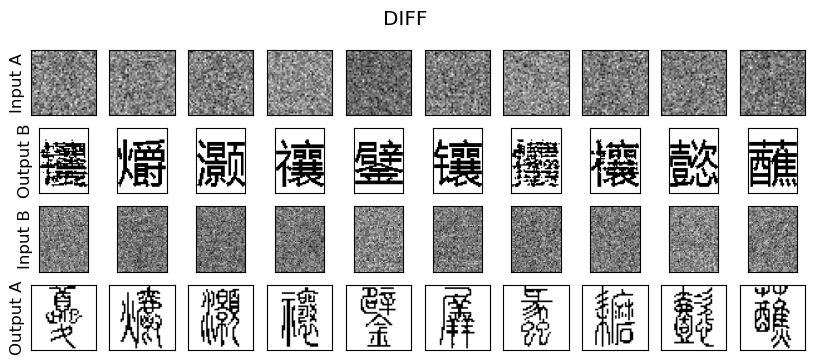

In [17]:
title = ['SRA', 'ORTH', 'SAME', 'DIFF']

for iy in range(4):
    md = models[iy]
    counter = 1
    n_recursive = 10
    adv_a, adv_b = attacker.forward(pat_a, pat_b)
    
    plt.figure(figsize=(10, 10))
    plt.suptitle(title[iy], y=0.92)
    for ix in range(10):

        plt.subplot(10, 10, counter)
        pat = adv_a[ix].detach().numpy()
        plt.imshow(pat.reshape(40, 40), cmap='binary')
        if ix == 0:
            plt.ylabel('Input A')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        counter += 1

    for ix in range(10):

        plt.subplot(10, 10, counter)
        pat = adv_a[ix]
        res = md.a_query_b(pat, n_recursive).detach().numpy()
        plt.imshow(np.sign(res).reshape(53, 40), cmap='binary')
        if ix == 0:
            plt.ylabel('Output B')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        counter += 1

    
    for ix in range(10):

        plt.subplot(10, 10, counter)
        pat = adv_b[ix].detach().numpy()
        plt.imshow(pat.reshape(53, 40), cmap='binary')
        if ix == 0:
            plt.ylabel('Input B')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        counter += 1

    for ix in range(10):

        plt.subplot(10, 10, counter)
        pat = adv_b[ix]
        res = md.b_query_a(pat, n_recursive).detach().numpy()
        plt.imshow(np.sign(res).reshape(40, 40), cmap='binary')
        if ix == 0:
            plt.ylabel('Output A')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        counter += 1
